# SNV Frequency Spectrum 

**Date**: 2020-02-18   
**Author**: Katarina Braun 

## Overview
This notebook plots SNV frequency spectrums.  
I think I am most interested in comparing SNP Frequency Spectrums in the SNP populations before and after transmission. I think I'll start by looking just two timepionts -- right before and after transmission. I'll start with pair1, pair7 and pair8.

**From Moncla et al, 2019, bioRxiv (https://doi.org/10.1101/683151):**  
"Purifying selection removes new variants from the population, generating an excess of low-freq variants, while positive selection promotes accumulation of high-frequency polymorphisms. Exponential population expansion also causes excess low-frequency variation; however, while selection disproportionately affects nonsynonymous variants, demographic factors affect synonymous and nonsynonymous variants equally."

I'll look for evidence of postive vs purifying selection following the transmission event. And, at least for now, I'll look across the entire genome. I could theoretically plot these for each gene segment, but I don't know if I have enough SNP calls to make anything out of that. 

Y = proportion of SNVs
X = within-host SNV frequency bins: 1-10%, 10-20%, 20-30%, 30-40%, 40-50%

I will also try to derive the "neutral expectation" -- that is the distribution of SNPs expected for a given population assuming that the population is not under selection and is at some sort of steady-state equilibrium. 

For the neutral expectation, Trevor Bedford suggests this will follow a 1/x distribution. I can then just integrate over a 1/x distribution between each bin size (0.01 to 0.1, 0.1 to 0.2, etc...). Then I'll calculate the proportion of the total that fall into each bin. Dr. Louise Moncal (cited above) already prepared a notebook to do this: `neutral-expectation.ipynb`, which I am going to utilize here. 
    
## Input: 

`SNVs/cleaned/*`

## Output: 

`SNP_frequency_spectrum/SFS.pdf`

## import modules and dependecies 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from itertools import cycle, islice
import random 
from pylab import *
from matplotlib.ticker import StrMethodFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv
import sys, subprocess, glob, os, shutil, re, importlib, Bio
from subprocess import call
from Bio import SeqIO
from scipy import stats
from scipy.integrate import quad
import seaborn as sns
import os
import seaborn as sns; sns.set()
from matplotlib import pyplot
from functools import reduce
import matplotlib as mpl
from matplotlib import gridspec
import itertools
import pysam
import matplotlib.patches as mpatches
import random 
from pylab import *
from matplotlib.font_manager import FontProperties 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib import gridspec

## Add in neutral expectation as a dashed line

The neutral expectation code is from Dr. Louise Moncla (https://github.com/lmoncla). 

The expectation for the proportion of variants in each frequency bin is given by a 1/x distribution. I will integrate the area under the curve for a 1/x distribution between each interval and plot this expected value.

In [2]:
# define functions 

def integrate_over_bins(lower_bound,upper_bound):
    # generate lambda function for 1/x
    f= lambda x:(1/x)

    # integrate between bins 
    integral = quad(f, lower_bound, upper_bound)[0]
    return(integral)

def return_area_under_curve(bins):

    total_area_under_curve = 0
    integrals = []
    
    for i in range(len(bins)-1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        integral = integrate_over_bins(lower_bound,upper_bound)
        integrals.append(integral)
        
    total_area_under_curve = np.asarray(integrals).sum()
    return(total_area_under_curve, integrals)

def return_neutral_expectation(total_area_under_curve, integrals):
    proportions = []
    for i in integrals: 
        proportion = i/total_area_under_curve
        proportions.append(proportion)
        
    return(proportions)

In [3]:
# predict neutral expectations for 10 bins 
bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
total_area_under_curve, integrals = return_area_under_curve(bins)
proportions = return_neutral_expectation(total_area_under_curve, integrals)
neutral_df = pd.DataFrame({"bin":["1-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-99%"],"expected":proportions})
neutral_df.set_index('bin', inplace=True)
neutral_df.rename(columns={'expected':'neutral expectation'}, inplace=True)

## Defines functions 

In [4]:
def load_SNVs(sample): 
    i = pd.read_csv('../SNVs/cleaned/' + sample + '-cleaned.csv', sep='\t')
    # modify the dataframes to retain only SNP and frequency 
    # drop any rows with SNPs between 99 and 100% frequency
    i = i[['SNP', '% of population']]
    i = i[~(i['% of population'] >= 99) & (i['% of population'] <= 100)]
    # sort SNPs by frequency 
    i = i.sort_values(by=['% of population'], ascending=False)
    # drop the SNP column and keep frequency only, identity of the SNP doesn't matter for this 
    i = i[['% of population']]
    # determine the number of SNPs so I can determine proportions
    i_num_snps = len(i.index)
    # count the number of SNPs within frequency bins 
    # bins: 1-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90, 90-99
    i_SFS = i.apply(pd.Series.value_counts, bins=[1,10,20,30,40,50,60,70,80,90,99])
    # replace counts with proportions 
    i_SFS['proportion of SNVs'] = i_SFS['% of population'].div(i_num_snps)
    i_SFS = i_SFS[['proportion of SNVs']]
    i_SFS = i_SFS.sort_index(ascending=True)
    i_SFS_new = i_SFS.reset_index()
    i_SFS_new = i_SFS_new.rename(index={0:'1-10%', 1:'10-20%', 2:'20-30%', 3:'30-40%', 4:'40-50%', 5:'50-60%', 6:'60-70%', 7:'70-80%', 8:'80-90%', 9:'90-99%'})
    i_SFS_new = i_SFS_new[['proportion of SNVs']]
    i_SFS_new.rename(columns={'proportion of SNVs':'index'}, inplace=True)
    return(i_SFS_new)

In [6]:
# run the above function on all samples
swab = load_SNVs('swab')
vero76 = load_SNVs('vero76')
veroE6 = load_SNVs('veroE6')
veroSTAT1KO = load_SNVs('veroSTAT1KO')

## Generate Plot 7 

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


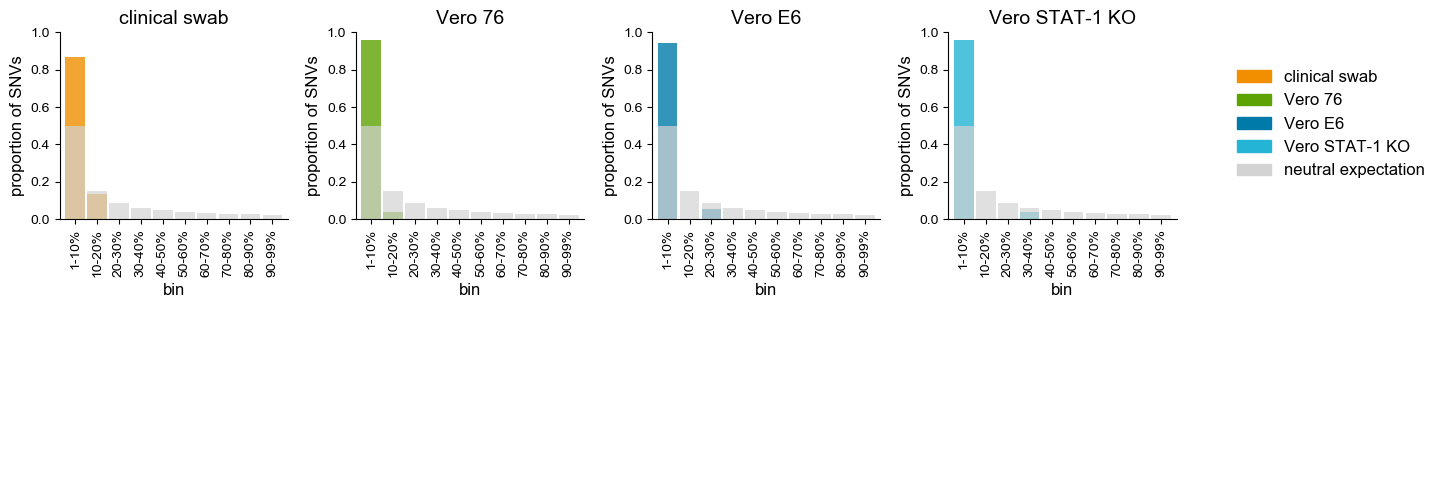

In [8]:
# define hex colors
swab_C = '#F18F01'
vero_76 = '#5EA304'
vero_E6 = '#007BA9'
vero_STAT1KO = '#23B5D3'

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(10,6), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(3, 4)

ax1 = fig.add_subplot(gs[0,0:1]) #swab
ax7 = fig.add_subplot(gs[0,1:2]) #1
ax8 = fig.add_subplot(gs[0,2:3]) #2
ax9 = fig.add_subplot(gs[0,3:4]) #3

# get right of top and right frame of each subplot
axes = (ax1, ax7, ax8, ax9)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    
# swab
swab_colors = ([swab_C, 'lightgrey'])
swab.plot(kind='bar', grid=False, color=swab_colors, figsize=(12,8), width=0.9, alpha=0.8, ax=ax1, legend=False)
ax1.set_title('clinical swab', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0,1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax1.set_xlabel('within-host SNV frequency (%)', fontname='Arial', fontsize=12)
ax1.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# vero76
vero76_colors = (['#5EA304', 'lightgrey'])
vero76.plot(kind='bar', grid=False, color=vero76_colors, figsize=(12,8), width=0.9, alpha=0.8, ax=ax7, legend=False)
ax7.set_title('Vero 76', fontname='Arial', fontsize=14)
ax7.set_facecolor('white')
for tick in ax7.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax7.get_yticklabels():
    tick.set_fontname("Arial")
ax7.set_ylim(0,1.0)
ax7.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax7.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax7.set_xlabel('within-host SNV frequency (%)', fontname='Arial', fontsize=12)
ax7.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# veroE6
veroE6_colors = (['#007BA9', 'lightgrey'])
veroE6.plot(kind='bar', grid=False, color=veroE6_colors, figsize=(12,8), width=0.9, alpha=0.8, ax=ax8, legend=False)
ax8.set_title('Vero E6', fontname='Arial', fontsize=14)
ax8.set_facecolor('white')
for tick in ax8.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax8.get_yticklabels():
    tick.set_fontname("Arial")
ax8.set_ylim(0,1.0)
ax8.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax8.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax8.set_xlabel('within-host SNV frequency (%)', fontname='Arial', fontsize=12)
ax8.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# veroSTAT1KO
veroE6_colors = (['#23B5D3', 'lightgrey'])
veroSTAT1KO.plot(kind='bar', grid=False, color=veroE6_colors, figsize=(12,8), width=0.9, alpha=0.8, ax=ax9, legend=False)
ax9.set_title('Vero STAT-1 KO', fontname='Arial', fontsize=14)
ax9.set_facecolor('white')
for tick in ax9.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax9.get_yticklabels():
    tick.set_fontname("Arial")
ax9.set_ylim(0,1.0)
ax9.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax9.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=12)
ax9.set_xlabel('within-host SNV frequency (%)', fontname='Arial', fontsize=12)
ax9.set_xticklabels(['1-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-99%'], fontname='Arial', fontsize=10, minor=False, rotation=45)

# plot neutral expectation
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax1, legend=False)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax7, legend=False)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax8, legend=False)
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.7, ax=ax9, legend=False)

# add a legend to this plot (none at the moment)
swabC = mpatches.Patch(color='#F18F01', label='clinical swab')
vero76C = mpatches.Patch(color='#5EA304', label='Vero 76')
veroE6C = mpatches.Patch(color='#007BA9', label='Vero E6')
veroSTAT1KOC = mpatches.Patch(color='#23B5D3', label='Vero STAT-1 KO')
neutral = mpatches.Patch(color='lightgrey', label='neutral expectation')
fig.legend(handles=[swabC, vero76C, veroE6C, veroSTAT1KOC, neutral], frameon=False, fontsize=12, bbox_to_anchor=(1.2,0.55))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("SFS.pdf", bbox_inches='tight', dpi=300)